In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from data_preprocessing.get_stnthetic_data import *

## Load dataset

In [38]:
train_set_bs, test_set_bs, train_set_ps, test_set_ps, train_set_po, test_set_po = get_synthetic_data(train_set_ratio=0.7, k=3)
print(type(train_set_po))

def input(train):
    X = train.iloc[:, :-1].values
    print(X.shape)
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    target_col = train.columns[-1]
    print(target_col)
    y = train[target_col].values
    print("Label distribution:", Counter(y))
    return X_scaled, y

X_scaled, y = input(train_set_po)

<class 'pandas.core.frame.DataFrame'>
(400, 110)
Progression occurrence
Label distribution: Counter({0.0: 200, 1.0: 200})


### Data Preparation

In [39]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


### Define MLP

In [40]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x


### Training

In [41]:
# Instantiate model
model = MLP(input_size=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# Training Loop
num_epochs = 40
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
log_data = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct_train += (predictions == labels).sum().item()
        total_train += labels.size(0)
    
    # Evaluate
    model.eval()
    test_loss = 0.0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct_test += (predictions == labels).sum().item()
            total_test += labels.size(0)
    
    train_loss_avg = running_loss / len(train_loader)
    test_loss_avg = test_loss / len(val_loader)
    train_accuracy = correct_train / total_train
    test_accuracy = correct_test / total_test
    
    train_losses.append(train_loss_avg)
    test_losses.append(test_loss_avg)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    log_data.append([epoch+1, train_loss_avg, test_loss_avg, train_accuracy, test_accuracy])
    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss_avg:.4f}, val Loss: {test_loss_avg:.4f}, Train Acc: {train_accuracy:.4f}, val Acc: {test_accuracy:.4f}')

# Save logs
log_df = pd.DataFrame(log_data, columns=['Epoch', 'Train Loss', 'val Loss', 'Train Accuracy', 'val Accuracy'])
log_df.to_csv('logs.csv', index=False)


Epoch 1/40 - Train Loss: 0.6783, val Loss: 0.6643, Train Acc: 0.5875, val Acc: 0.6125
Epoch 2/40 - Train Loss: 0.6300, val Loss: 0.6050, Train Acc: 0.8375, val Acc: 0.9000
Epoch 3/40 - Train Loss: 0.5534, val Loss: 0.5041, Train Acc: 0.9594, val Acc: 0.9875
Epoch 4/40 - Train Loss: 0.4407, val Loss: 0.3787, Train Acc: 0.9750, val Acc: 1.0000
Epoch 5/40 - Train Loss: 0.3352, val Loss: 0.2629, Train Acc: 0.9938, val Acc: 1.0000
Epoch 6/40 - Train Loss: 0.2264, val Loss: 0.1714, Train Acc: 1.0000, val Acc: 1.0000
Epoch 7/40 - Train Loss: 0.1412, val Loss: 0.1010, Train Acc: 1.0000, val Acc: 1.0000
Epoch 8/40 - Train Loss: 0.0771, val Loss: 0.0534, Train Acc: 1.0000, val Acc: 1.0000
Epoch 9/40 - Train Loss: 0.0427, val Loss: 0.0279, Train Acc: 1.0000, val Acc: 1.0000
Epoch 10/40 - Train Loss: 0.0230, val Loss: 0.0173, Train Acc: 1.0000, val Acc: 1.0000
Epoch 11/40 - Train Loss: 0.0142, val Loss: 0.0131, Train Acc: 1.0000, val Acc: 1.0000
Epoch 12/40 - Train Loss: 0.0088, val Loss: 0.0109, 

### Loss and accuracy visualization

In [42]:
def plot(log, title):
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(log['Epoch'], log['Train Loss'], label='Train Loss')
    plt.plot(log['Epoch'], log['val Loss'], label='val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(log['Epoch'], log['Train Accuracy'], label='Train Accuracy')
    plt.plot(log['Epoch'], log['val Accuracy'], label='val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    
    plt.suptitle(title)
    plt.show()

#### Progression Occurence

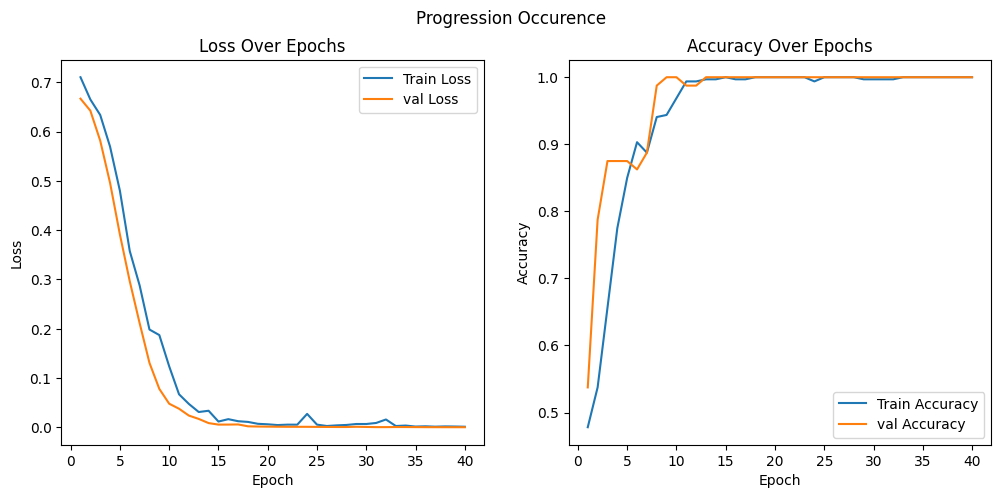

In [36]:
log_path = "/Users/ccy/Documents/CMU/Spring2025/42687 Projects in Biomedical AI/Final Project/Explainable Deep Learning on Multimodal Patient Data for Predicting Immunotherapy Outcomes in Metastatic Non-small Cell Lung Cancer/logs_progression_occurence.csv"
log = pd.read_csv(log_path)
plot(log,"Progression Occurence")

### Test on real data

In [ ]:
train_set_bs, test_set_bs, train_set_ps, test_set_ps, train_set_po, test_set_po = get_synthetic_data(train_set_ratio=0.7, k=3)
print(type(test_set_po))

X_test, y_test = input(test_set_po)

<class 'pandas.core.frame.DataFrame'>
(22, 110)
Progression occurrence
Label distribution: Counter({0.0: 16, 1.0: 6})


In [28]:
# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=73, shuffle=False)

In [ ]:
all_predictions = []
all_labels = []

with torch.no_grad():
    model.eval()
    for inputs, labels in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predictions = (outputs > 0.5).float()
        correct_test += (predictions == labels).sum().item()
        total_test += labels.size(0)
        
        # Collect results
        all_predictions.extend(predictions.cpu().numpy().flatten().tolist())
        all_labels.extend(labels.cpu().numpy().flatten().tolist())
    
    test_loss_avg = test_loss / total_test
    test_accuracy = correct_test / total_test

print(f'Test Loss: {test_loss_avg:.4f}, Test Accuracy: {test_accuracy:.4f}')
# Now safe to create DataFrame
df = pd.DataFrame({
    'Predictions': all_predictions,
    'Labels': all_labels
})
print(df)

Test Loss: 0.0200, Test Accuracy: 0.9158
    Test Loss  Test Accuracy  Predictions  Labels
0    3.808325       0.915789          0.0     0.0
1    3.808325       0.915789          0.0     0.0
2    3.808325       0.915789          1.0     1.0
3    3.808325       0.915789          0.0     0.0
4    3.808325       0.915789          0.0     1.0
5    3.808325       0.915789          1.0     1.0
6    3.808325       0.915789          0.0     0.0
7    3.808325       0.915789          0.0     0.0
8    3.808325       0.915789          1.0     1.0
9    3.808325       0.915789          0.0     0.0
10   3.808325       0.915789          1.0     0.0
11   3.808325       0.915789          0.0     0.0
12   3.808325       0.915789          0.0     0.0
13   3.808325       0.915789          0.0     0.0
14   3.808325       0.915789          1.0     1.0
15   3.808325       0.915789          0.0     0.0
16   3.808325       0.915789          1.0     1.0
17   3.808325       0.915789          0.0     0.0
18   3.80